Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
from lab9_lib import make_problem
from random import choices
import numpy as np
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt

POP_SIZE = 40 #population size
OFF_SIZE = 40 #offspring size
NUM_GEN = 1_000
ELEMENTS_SWAPPED = 5
MIG_STEP = 10  # after how many steps a miggration between the 2 islands occurs
NUM_MUT = 0
TOURNAMENT_SIZE = POP_SIZE//2 # how many random individuals are picked for the parent selection in each island
MUT_CHANCE = 0.3  # chance a new individual has to mutate
MOD_GENES = 3 # how many genes mutate if mutation occurs
N_ISLANDS = 4 # number of islands
PROB_INST = 10 #instance of the problem

In [2]:
# from random import choices
# import numpy as np
# from tqdm import tqdm
# from collections import Counter
# from matplotlib import pyplot as plt


# # Copyright © 2023 Giovanni Squillero <giovanni.squillero@polito.it>
# # https://github.com/squillero/computational-intelligence
# # Free for personal or classroom use; see 'LICENSE.md' for details.

# from abc import abstractmethod


# class AbstractProblem:
#     def __init__(self):
#         self._calls = 0

#     @property
#     @abstractmethod
#     def x(self):
#         pass

#     @property
#     def calls(self):
#         return self._calls

#     @staticmethod
#     def onemax(genome):
#         return sum(bool(g) for g in genome)

#     def __call__(self, genome):
#         self._calls += 1
#         fitnesses = sorted((AbstractProblem.onemax(genome[s :: self.x]) for s in range(self.x)), reverse=True)
#         val = sum(f for f in fitnesses if f == fitnesses[0]) - sum(
#             f * (0.1 ** (k + 1)) for k, f in enumerate(f for f in fitnesses if f < fitnesses[0])
#         )
#         return val / len(genome)


# def make_problem(a):
#     class Problem(AbstractProblem):
#         @property
#         @abstractmethod
#         def x(self):
#             return a

#     return Problem()


In [3]:
assert N_ISLANDS >= 2, "You need at least 2 islands"

In [4]:
fitness = make_problem(PROB_INST)

In [5]:
def mutation1(ind, prob):  # mutation consists in inverting one single random gene
    global NUM_MUT
    if np.random.random() <= prob:
        mod_genes = np.random.choice(range(len(ind)), size=MOD_GENES, replace=False)
        for i in mod_genes:
            ind[i] = 1 - ind[i] # 0 -> 1, 1 -> 0
        NUM_MUT = NUM_MUT + 1
    return ind

def mutation2(ind, prob):
    global NUM_MUT

    for g in range(len(ind)):
        if np.random.random() <= prob:
            ind[g] = 1 - ind[g]
            NUM_MUT = NUM_MUT + 1
    return ind 


def uniform_crossover(p1, p2):  
    her1 = sorted(list(np.random.choice(range(len(p1)), size=len(p1)//2, replace=False))) # First parent transmits half of his genes to the new individual
    her2 = sorted(list(set(range(len(p2))).difference(set(her1)))) # The second parent transmits the half the first parent doesn't give 

    new_ind = [0] * len(p1)
    for i in her1:
        new_ind[i] = p1[i]
    for i in her2:
        new_ind[i] = p2[i]
    return new_ind

def two_point_crossover(p1, p2):
    c = np.random.randint(0, len(p1))
    d = np.random.randint(0, len(p2))

    if d < c:
        swap = c
        c = d
        d = swap
        
    for i in range(c, d + 1, 1):
        swap = p1[i]
        p1[i] = p2[i]
        p2[i] = swap
    
    return p1, p2

def tournament_selection1(pop):  # This parent selection is based on the fitness. The 2 fittest individuals end up being the parents
    participants = sorted(list(np.random.choice(range(len(pop)), size = TOURNAMENT_SIZE, replace=False)), key=lambda e: pop[e][1], reverse=True)
    return pop[participants[0]], pop[participants[1]]

def tournament_selection2(pop):  # This parent selection looks for the 2 individuals that are the most different from a random pool
    hashed_pop = [("".join(str(e) for e in p[0]), p[1]) for p in pop] # we need to turn the genome into a string to hash it and make every individual unique
    ph = list(set(hashed_pop)) # we make the individuals unique to avoid having 2 identical parents
    p = [([int(e) for e in list(el[0])], el[1]) for el in ph]
    participants = np.random.choice(range(len(p)), size = TOURNAMENT_SIZE if len(p) > TOURNAMENT_SIZE else len(p), replace=False)
    parents_difference = []
    for p1 in participants:
        parents_difference.append((p1, compute_diff(pop[p1], pop)))
    parents_difference = sorted(parents_difference, reverse=True, key=lambda e: e[1])  # List is sorted based on the sum of all the hamming distances for a given individual 
    return p[parents_difference[0][0]], p[parents_difference[1][0]]  # Returns the 2 most different individuals

def tournament_selection3(pop):
    participants = np.random.choice(range(len(pop)), size = TOURNAMENT_SIZE, replace=False)
    parents = []
    for p1 in participants:
        parents.append((p1, pop[p1][1])) #(index of the individual, fitness)
    winner = max(parents, key=lambda e: e[1])[0] 
    return pop[winner]

def migration1(pop1, pop2):  
    i1 = np.random.randint(0, len(pop1))
    i2 = np.random.randint(0, len(pop2))

    swap = pop1[i1]
    pop1[i1] = pop2[i2]
    pop2[i2] = swap

    return sorted(pop1, key=lambda e: e[1], reverse= True), sorted(pop2, key=lambda e: e[1], reverse=True)

def migration2(pop1, pop2):
    # Before swapping the individuals between the 2 choses islands, 
    # we search for the individuals of an island that are the most different from the individuals the other island to ensure
    # that the swap provides a benefit in terms of diversity
    
    p1_difference = []  # These lists are used to keep track of the differences
    p2_difference = []

    for i1 in range(len(pop1)):  # Computes the differences for each individual
        p1_difference.append((i1, compute_diff(pop1[i1], pop2)))
    for i2 in range(len(pop2)):
        p2_difference.append((i2, compute_diff(pop2[i2], pop1)))
    
    e1 = sorted(p1_difference, key=lambda e: e[1], reverse=True)[0:ELEMENTS_SWAPPED] # Retrieves the indexes of the 2 individuals we want to swap
    e2 = sorted(p2_difference, key=lambda e: e[1], reverse=True)[0:ELEMENTS_SWAPPED]

    for i in range(ELEMENTS_SWAPPED):
        swap = pop1[e1[i][0]]
        pop1[e1[i][0]] = pop2[e2[i][0]]
        pop2[e2[i][0]] = swap
    # swap = pop1[e1]  # Swap
    # pop1[e1] = pop2[e2]
    # pop2[e2] = swap

    return sorted(pop1, key=lambda e: e[1], reverse= True), sorted(pop2, key=lambda e: e[1], reverse=True)

def check_inequality(pop):
    e = pop[0]
    for i in pop:
        if e[0] != i[0]:
            return True
    return False

def hamming_dist(ind1, ind2):
    return sum(np.array(ind1) != np.array(ind2))

def compute_diff(ind, pop):  # computes the complexive hamming distance between an individual and an entire population
    diff = 0
    for p in pop:
        diff += hamming_dist(ind[0], p[0])
    return diff

def remove_most_common(pop):
    hashed_pop = [("".join(str(e) for e in p[0]), p[1]) for p in pop] # we need to turn the genome into a string to hash it
    m = Counter(hashed_pop).most_common(1) # the result is in the form [((genome, fitness), #occurrences)]
    if m[0][1] >= POP_SIZE/10:
        for _ in range(m[0][1] - 1):
            i = hashed_pop.index(m[0][0])
            new_ind = choices([0, 1], k=1000)
            pop[i] = (new_ind, fitness(new_ind))
    return pop
        

In [6]:
migration = migration2
tournament_selection = tournament_selection3
mutation = mutation2
crossover = two_point_crossover

In [7]:
# start by creating the initial population
population = []  #every element will correspond to the population of an island
Same_parents = False
fit_history = []
fit_history_per_island = [[] for _ in range(N_ISLANDS)]
generations = []

for island in range(N_ISLANDS):
    p = []
    for _ in range(POP_SIZE):
        ind = choices([0, 1], k=1000)
        p.append((ind, fitness(ind)))
    population.append(p)

for gen in tqdm(range(NUM_GEN)):

    for island in range(N_ISLANDS):
        # population[island] = remove_most_common(population[island])
        parents = []
        parents.append(tournament_selection(population[island]))
        parents.append(tournament_selection(population[island]))
        if parents[0] == parents[1]:
            Same_parents=True
        
        off = []
        c1, c2 = crossover(parents[0][0].copy(), parents[1][0].copy())

        avg_fit = np.average([e[1] for e in population[island]])
        count = 0
        for e in population[island]:
            if e[1] < avg_fit:
                count += 1
        if count >= POP_SIZE // 2:
            mut_prob = POP_SIZE / (count * len(c1))
        else:
            mut_prob = 1 / len(c1) 
        c1 = mutation(c1, mut_prob)
        c2 = mutation(c2, mut_prob)
        off.append((c1,fitness(c1)))
        off.append((c2, fitness(c2)))
        
        population[island] = sorted(population[island] + off, key=lambda e: e[1], reverse=True)[0:POP_SIZE]

    if (gen + 1) % MIG_STEP == 0:  #perform the migration
        isl = np.random.choice(range(len(population)), size=2, replace=False) # select 2 islands to perform the swap
        population[isl[0]], population[isl[1]] = migration(population[isl[0]], population[isl[1]])

    for i in range(N_ISLANDS):
        fit_history_per_island[i].append(population[i][0][1])

    # for i in range(len(population)):
    #     if check_inequality(population[i]) == False:
    #         print(f"{i + 1}-th island is fully equal at {gen + 1}-th iteration")

    top = []
    for p in population:
        top.append(p[0])
    best = max(top, key=lambda e: e[1])
    generations.append(gen + 1)
    fit_history.append(best[1])

    if best[1] == 1:
        break

print(f"Best individual: {''.join(str(g) for g in best[0])}")
print(f"Best fitness: {best[1]:.2%}")
print(f"Number of fitness calls: {fitness.calls}")
print(f"Number of mutations: {NUM_MUT}")

for i in range(len(population)):
    print(f"Inequality island {i + 1}: {check_inequality(population[i])}")
print(f"Same parents: {Same_parents}")


100%|██████████| 1000/1000 [00:46<00:00, 21.32it/s]

Best individual: 00000100001100000001101000000101000100010101001001010000000101000100000000010011010101000000000100010100110011000001001100000011100101010011010001010000000000110010010000010000000100000000001000000110010101000001000100000010011010010001000101000000001000010001010000000110010110010001110001000001000001000100010100000000010010000100000110110010011000010010010100000000001001001010010010000101000001100100000000011000100001001000010000010101010011000011100101000110011001100001000101110101010001000000010000001010000111001101000011010101100101110100000000000101010000000100001100010000010000000001010100110000001010110001110000010000010000011100000100100000001101100010100100000001010001001110000000010100011001011001001000001100010000110001011001000100100000010101001001111011000010000101010100010001001011001101001100010100010010010011110001000000010100010100110001010100110000010100001000000111010011001000010001010000000001000011000010100001100000011101010001000110010110010001010

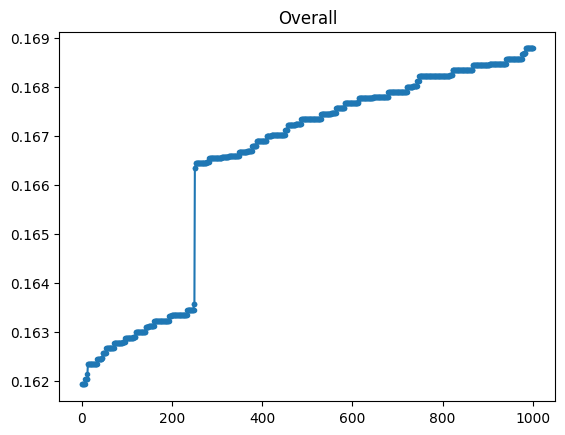

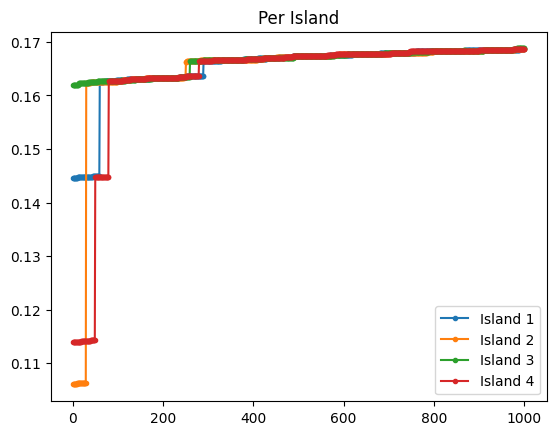

In [8]:
plt.figure()
plt.title("Overall")
plt.plot(np.array(generations), np.array(fit_history), marker='.')

plt.figure()
plt.title("Per Island")
legends = []
for i in range(N_ISLANDS):
    legends.append(f"Island {i + 1}")
    plt.plot(np.array(generations), np.array(fit_history_per_island[i]), marker='.')
plt.legend(legends)
